In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Cargar el modelo
model_path = 'modelos_moe/CORVINA_cluster_7_moe_model.h5'
model = tf.keras.models.load_model(model_path)

# Crear una entrada de prueba con la misma forma esperada por la capa de entrada del modelo
test_input = np.random.random((1, 6, 14))  # Ajusta las dimensiones según la estructura del modelo


# Obtener las activaciones de los submodelos
def get_submodel_activations(submodel, input_data):
    layer_outputs = [layer.output for layer in submodel.layers]
    activation_model = tf.keras.models.Model(inputs=submodel.input, outputs=layer_outputs)
    activations = activation_model.predict(input_data)
    return activations

# Recorremos los submodelos individualmente
submodel_activations = {}

# Verifica los nombres de los submodelos en tu modelo
for layer in model.layers:
    if 'model' in layer.name:  # Esto verifica si es un submodelo
        print(f"Procesando activaciones de {layer.name}")
        activations = get_submodel_activations(layer, test_input)
        submodel_activations[layer.name] = activations

# Ahora ya tenemos las activaciones de cada submodelo
# Puedes iterar sobre submodel_activations y graficar cada submodelo


Procesando activaciones de model
1/1 [==============================] - 1s 1s/step
Procesando activaciones de model_1
1/1 [==============================] - 0s 69ms/step
Procesando activaciones de model_2
1/1 [==============================] - 0s 78ms/step


In [10]:
# Cargar el modelo
model_path = 'modelos_moe/CORVINA_cluster_7_moe_model.h5'
model = tf.keras.models.load_model(model_path)
csv_file_path = 'activation_values.csv'

# Preparar el archivo CSV
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Modelo', 'Submodelo', 'Capa', 'Neurona', 'Valor'])

# Obtener las activaciones de los submodelos
def get_submodel_activations(submodel, input_data):
    layer_outputs = [layer.output for layer in submodel.layers]
    activation_model = tf.keras.models.Model(inputs=submodel.input, outputs=layer_outputs)
    activations = activation_model.predict(input_data)
    return activations

# Cargar los datos de entrada de ejemplo
input_data = np.random.random((1, 6, 14))  # Ajusta las dimensiones según la estructura del modelo

# Recorremos los submodelos individualmente
submodel_activations = {}

# Verifica los nombres de los submodelos en tu modelo
for layer in model.layers:
    if 'model' in layer.name:  # Esto verifica si es un submodelo
        print(f"Procesando activaciones de {layer.name}")
        activations = get_submodel_activations(layer, input_data)
        submodel_activations[layer.name] = activations

# Guardar los valores de activación en el archivo CSV
with open(csv_file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    for submodel_name, activations in submodel_activations.items():
        for layer_index, layer_activation in enumerate(activations):
            layer_name = model.get_layer(submodel_name).layers[layer_index].name
            if len(layer_activation.shape) > 2:  # Reducir dimensiones si es necesario
                layer_activation = np.mean(layer_activation, axis=(1, 2))
            for neuron_index, neuron_value in enumerate(layer_activation.flatten()):
                writer.writerow(['Modelo MoE', submodel_name, layer_name, neuron_index, neuron_value])

print(f'Los valores de activación han sido guardados en {csv_file_path}')


Procesando activaciones de model
1/1 [==============================] - 1s 1s/step
Procesando activaciones de model_1
1/1 [==============================] - 0s 70ms/step
Procesando activaciones de model_2
1/1 [==============================] - 0s 80ms/step
Los valores de activación han sido guardados en activation_values.csv


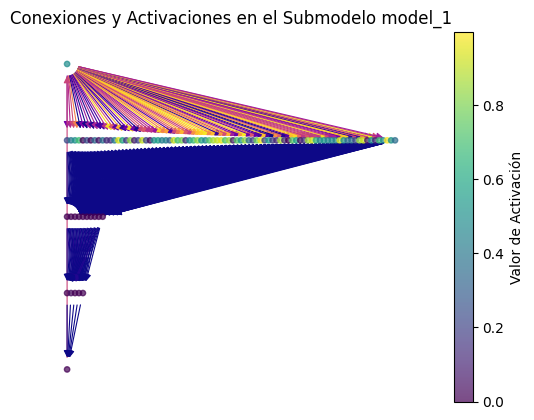

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# Cargar los datos
file_path = 'activation_values.csv'  # Cambia esto a la ruta donde está tu archivo
activations = pd.read_csv(file_path)


# Filtrar los datos por submodelo
submodelo = 'model_1'  # Puedes cambiar esto para analizar otros submodelos
filtered_data = activations[activations['Submodelo'] == submodelo]

# Crear un grafo para visualizar las conexiones entre neuronas
G = nx.DiGraph()

# Agregar nodos y aristas al grafo
for _, row in filtered_data.iterrows():
    capa = row['Capa']
    neurona = row['Neurona']
    valor = row['Valor']
    nodo = f'{capa}_n{neurona}'
    G.add_node(nodo, capa=capa, valor=valor)
    
    # Conectar neuronas entre capas consecutivas
    if capa != 'input_1':
        prev_capa = filtered_data['Capa'].unique()[list(filtered_data['Capa'].unique()).index(capa) - 1]
        prev_neuronas = filtered_data[filtered_data['Capa'] == prev_capa]['Neurona'].unique()
        for prev_neurona in prev_neuronas:
            prev_nodo = f'{prev_capa}_n{prev_neurona}'
            G.add_edge(prev_nodo, nodo, weight=valor)

# Dibujar el grafo
layer_positions = {}
y_offset = 0

# Asignar posiciones para las neuronas organizadas por capas de arriba a abajo
for layer in filtered_data['Capa'].unique():
    neurons_in_layer = filtered_data[filtered_data['Capa'] == layer]['Neurona'].unique()
    x_positions = list(range(len(neurons_in_layer)))
    for i, neuron in enumerate(neurons_in_layer):
        node = f'{layer}_n{neuron}'
        layer_positions[node] = (i, -y_offset)
    y_offset += 2

edge_colors = [G[u][v]['weight'] for u, v in G.edges]
nodes = nx.draw_networkx_nodes(G, layer_positions, node_size=15, cmap=plt.cm.viridis, 
                               node_color=[data['valor'] for _, data in G.nodes(data=True)], alpha=0.7)
edges = nx.draw_networkx_edges(G, layer_positions, arrowstyle='-|>', arrowsize=10, edge_color=edge_colors, edge_cmap=plt.cm.plasma, width=.8)

plt.title(f'Conexiones y Activaciones en el Submodelo {submodelo}')
plt.colorbar(nodes, label='Valor de Activación')
plt.axis('off')
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import networkx as nx

# Cargar el modelo
model_path = 'modelos_moe/CORVINA_cluster_7_moe_model.h5'
model = tf.keras.models.load_model(model_path)
csv_file_path = 'activation_values.csv'

# Preparar el archivo CSV
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Modelo', 'Submodelo', 'Capa', 'Neurona', 'Valor'])

# Obtener las activaciones de los submodelos
def get_submodel_activations(submodel, input_data):
    layer_outputs = [layer.output for layer in submodel.layers]
    activation_model = tf.keras.models.Model(inputs=submodel.input, outputs=layer_outputs)
    activations = activation_model.predict(input_data)
    return activations

# Cargar los datos de entrada de ejemplo
input_data = np.random.random((1, 6, 14))  # Ajusta las dimensiones según la estructura del modelo

# Recorremos los submodelos individualmente
submodel_activations = {}

# Verifica los nombres de los submodelos en tu modelo
for layer in model.layers:
    if 'model' in layer.name:  # Esto verifica si es un submodelo
        print(f"Procesando activaciones de {layer.name}")
        activations = get_submodel_activations(layer, input_data)
        submodel_activations[layer.name] = activations

# Guardar los valores de activación en el archivo CSV
with open(csv_file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    for submodel_name, activations in submodel_activations.items():
        for layer_index, layer_activation in enumerate(activations):
            layer_name = model.get_layer(submodel_name).layers[layer_index].name
            if len(layer_activation.shape) > 2:  # Reducir dimensiones si es necesario
                layer_activation = np.mean(layer_activation, axis=(1, 2))
            for neuron_index, neuron_value in enumerate(layer_activation.flatten()):
                writer.writerow(['Modelo MoE', submodel_name, layer_name, neuron_index, neuron_value])

print(f'Los valores de activación han sido guardados en {csv_file_path}')

# Cargar los datos
file_path = 'activation_values.csv'  # Cambia esto a la ruta donde está tu archivo
activations = pd.read_csv(file_path)


# Filtrar los datos por submodelo
submodelo = 'model_1'  # Puedes cambiar esto para analizar otros submodelos
filtered_data = activations[activations['Submodelo'] == submodelo]

# Crear un grafo para visualizar las conexiones entre neuronas
G = nx.DiGraph()

# Agregar nodos y aristas al grafo
for _, row in filtered_data.iterrows():
    capa = row['Capa']
    neurona = row['Neurona']
    valor = row['Valor']
    nodo = f'{capa}_n{neurona}'
    G.add_node(nodo, capa=capa, valor=valor)
    
    # Conectar neuronas entre capas consecutivas
    if capa != 'input_1':
        prev_capa = filtered_data['Capa'].unique()[list(filtered_data['Capa'].unique()).index(capa) - 1]
        prev_neuronas = filtered_data[filtered_data['Capa'] == prev_capa]['Neurona'].unique()
        for prev_neurona in prev_neuronas:
            prev_nodo = f'{prev_capa}_n{prev_neurona}'
            G.add_edge(prev_nodo, nodo, weight=valor)

# Dibujar el grafo
layer_positions = {}
y_offset = 0

# Asignar posiciones para las neuronas organizadas por capas de arriba a abajo
for layer in filtered_data['Capa'].unique():
    neurons_in_layer = filtered_data[filtered_data['Capa'] == layer]['Neurona'].unique()
    x_positions = list(range(len(neurons_in_layer)))
    for i, neuron in enumerate(neurons_in_layer):
        node = f'{layer}_n{neuron}'
        layer_positions[node] = (i, -y_offset)
    y_offset += 2

edge_colors = [G[u][v]['weight'] for u, v in G.edges]
nodes = nx.draw_networkx_nodes(G, layer_positions, node_size=15, cmap=plt.cm.viridis, 
                               node_color=[data['valor'] for _, data in G.nodes(data=True)], alpha=0.7)
edges = nx.draw_networkx_edges(G, layer_positions, arrowstyle='-|>', arrowsize=10, edge_color=edge_colors, edge_cmap=plt.cm.plasma, width=.8)

plt.title(f'Conexiones y Activaciones en el Submodelo {submodelo}')
plt.colorbar(nodes, label='Valor de Activación')
plt.axis('off')
plt.show()

Procesando activaciones de model_52
1/1 [==============================] - 1s 928ms/step
Procesando activaciones de model_53
1/1 [==============================] - 0s 77ms/step
Procesando activaciones de model_54
1/1 [==============================] - 0s 86ms/step
Los valores de activación han sido guardados en activation_values.csv


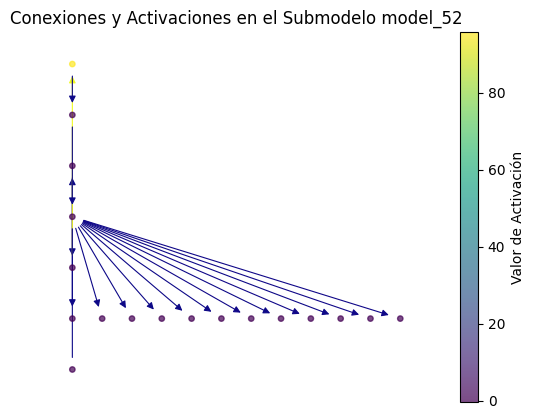

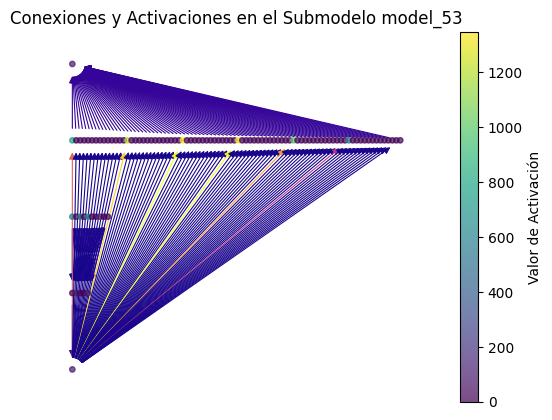

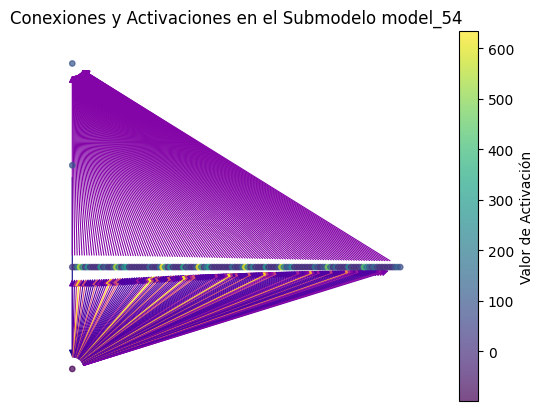

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import networkx as nx
import csv
import os

# Cargar el modelo
model_directory = 'modelos_moe'
model_files = [f for f in os.listdir(model_directory) if f.endswith('.h5')]
model_path = os.path.join(model_directory, model_files[0])  # Seleccionar el primer modelo encontrado
model = tf.keras.models.load_model(model_path)
csv_file_path = 'activation_values.csv'

# Cargar los datos de entrada desde un archivo CSV
input_data_path = 'input_test_data.csv'  # Ruta del archivo CSV con los datos de entrada
input_data = pd.read_csv(input_data_path, header=None).values.reshape((1, 6, 14))

# Obtener las activaciones de los submodelos
def get_submodel_activations(submodel, input_data):
    layer_outputs = [layer.output for layer in submodel.layers]
    activation_model = tf.keras.models.Model(inputs=submodel.input, outputs=layer_outputs)
    return activation_model.predict(input_data)

# Preparar el archivo CSV y guardar las activaciones
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Modelo', 'Submodelo', 'Capa', 'Neurona', 'Valor'])
    
    # Recorremos los submodelos individualmente
    for layer in model.layers:
        if 'model' in layer.name:  # Esto verifica si es un submodelo
            print(f"Procesando activaciones de {layer.name}")
            activations = get_submodel_activations(layer, input_data)
            for layer_index, layer_activation in enumerate(activations):
                layer_name = model.get_layer(layer.name).layers[layer_index].name
                if len(layer_activation.shape) > 2:  # Reducir dimensiones si es necesario
                    layer_activation = np.mean(layer_activation, axis=(1, 2))
                for neuron_index, neuron_value in enumerate(layer_activation.flatten()):
                    writer.writerow(['Modelo MoE', layer.name, layer_name, neuron_index, neuron_value])

print(f'Los valores de activación han sido guardados en {csv_file_path}')

# Cargar los datos
activations = pd.read_csv(csv_file_path)

# Filtrar los datos por cada submodelo y graficar
submodelos = activations['Submodelo'].unique()
for submodelo in submodelos:
    filtered_data = activations[activations['Submodelo'] == submodelo]

    # Crear un grafo para visualizar las conexiones entre neuronas
    G = nx.DiGraph()

    # Agregar nodos y aristas al grafo
    grouped_data = filtered_data.groupby('Capa')
    previous_layer_neurons = None
    for layer, data in grouped_data:
        current_layer_neurons = []
        for _, row in data.iterrows():
            capa = row['Capa']
            neurona = row['Neurona']
            valor = row['Valor']
            nodo = f'{capa}_n{neurona}'
            G.add_node(nodo, capa=capa, valor=valor)
            current_layer_neurons.append(nodo)
            
            # Conectar neuronas entre capas consecutivas
            if previous_layer_neurons is not None:
                for prev_nodo in previous_layer_neurons:
                    G.add_edge(prev_nodo, nodo, weight=valor)
        previous_layer_neurons = current_layer_neurons

    # Dibujar el grafo
    layer_positions = {}
    y_offset = 0

    # Asignar posiciones para las neuronas organizadas por capas de arriba a abajo
    for layer in filtered_data['Capa'].unique():
        neurons_in_layer = filtered_data[filtered_data['Capa'] == layer]['Neurona'].unique()
        x_positions = list(range(len(neurons_in_layer)))
        for i, neuron in enumerate(neurons_in_layer):
            node = f'{layer}_n{neuron}'
            layer_positions[node] = (i, -y_offset)
        y_offset += 2

    edge_colors = [G[u][v]['weight'] for u, v in G.edges]
    nodes = nx.draw_networkx_nodes(G, layer_positions, node_size=15, cmap=plt.cm.viridis, 
                                   node_color=[data['valor'] for _, data in G.nodes(data=True)], alpha=0.7)
    edges = nx.draw_networkx_edges(G, layer_positions, arrowstyle='-|>', arrowsize=10, edge_color=edge_colors, edge_cmap=plt.cm.plasma, width=0.8)

    plt.title(f'Conexiones y Activaciones en el Submodelo {submodelo}')
    plt.colorbar(nodes, label='Valor de Activación')
    plt.axis('off')
    plt.show()


In [30]:
# Cargar los datos de entrada desde un archivo CSV
input_data_path = 'input_test_data.csv'  # Ruta del archivo CSV con los datos de entrada
input_data = pd.read_csv(input_data_path, header=None)


In [32]:
input_data.shape

(6, 13)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import networkx as nx
import csv
import os

# Paths to the future data, predictions, and model directory
future_data_path = 'future_data.csv'
predictions_path = 'Resultados/predicciones_CORVINA_cluster_6.csv'
model_directory = 'modelos_moe'
output_directory = 'activation_graphs'


# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Load future_data and predictions data
future_data = pd.read_csv(future_data_path)
predictions = pd.read_csv(predictions_path)

# Rename columns to match the existing data format and facilitate merging
future_data.rename(columns={'year': 'Year', 'month': 'Month', 'cluster': 'Cluster'}, inplace=True)
predictions['Year'] = pd.to_datetime(predictions['date']).dt.year
predictions['Month'] = pd.to_datetime(predictions['date']).dt.month
predictions['Cluster'] = 6  # Assuming this is for cluster 6 based on the file name

# Filter future_data based on the cluster information
cluster_value = predictions['Cluster'].unique()[0]
filtered_future_data = future_data[future_data['Cluster'] == cluster_value]

# Combine predictions data with filtered future data
combined_data = pd.merge(predictions, filtered_future_data, on=['Year', 'Month', 'Cluster'], how='inner')

# Limit data to the first 10 years
combined_data['Date'] = pd.to_datetime(combined_data[['Year', 'Month']].assign(DAY=1))
combined_data = combined_data.sort_values('Date')

# Save the new combined data
combined_data_path = 'combined_data_for_activation.csv'
combined_data.to_csv(combined_data_path, index=False)

# Load the combined data for activations
input_data = pd.read_csv(combined_data_path)

# Limit the data to the columns representing input features (temperature, predictions, and cluster)
input_features = ['predictions', 'Cluster'] + [col for col in input_data.columns if 'depth' in col]

# Load the model
model_path = os.path.join(model_directory, 'CORVINA_cluster_6_moe_model.h5')  # Seleccionar un único modelo especificado
model = tf.keras.models.load_model(model_path)

# Obtener las activaciones de los submodelos
def get_submodel_activations(submodel, input_data):
    layer_outputs = [layer.output for layer in submodel.layers]
    activation_model = tf.keras.models.Model(inputs=submodel.input, outputs=layer_outputs)
    return activation_model.predict(input_data)

# Graficar activaciones para cada fecha pronosticada
for index, row in combined_data.iterrows():
    input_data = combined_data[input_features].iloc[index:index+6].values.astype(float).reshape((1, 6, len(input_features)))

    # Preparar el archivo CSV y guardar las activaciones
    csv_file_path = os.path.join(output_directory, f'activation_values_{index}.csv')
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Modelo', 'Submodelo', 'Capa', 'Neurona', 'Valor'])
        
        # Recorremos los submodelos individualmente
        for layer in model.layers:
            if 'model' in layer.name:  # Esto verifica si es un submodelo
                print(f"Procesando activaciones de {layer.name} para la fecha {row['Date']}")
                activations = get_submodel_activations(layer, input_data)
                for layer_index, layer_activation in enumerate(activations):
                    layer_name = model.get_layer(layer.name).layers[layer_index].name
                    if len(layer_activation.shape) > 2:  # Reducir dimensiones si es necesario
                        layer_activation = np.mean(layer_activation, axis=(1, 2))
                    for neuron_index, neuron_value in enumerate(layer_activation.flatten()):
                        writer.writerow(['Modelo MoE', layer.name, layer_name, neuron_index, neuron_value])

    # Cargar los datos de activación
    activations = pd.read_csv(csv_file_path)

    # Filtrar los datos por cada submodelo y graficar
    submodelos = activations['Submodelo'].unique()
    for submodelo in submodelos:
        filtered_data = activations[activations['Submodelo'] == submodelo]

        # Crear un grafo para visualizar las conexiones entre neuronas
        G = nx.DiGraph()

        # Agregar nodos y aristas al grafo
        grouped_data = filtered_data.groupby('Capa')
        previous_layer_neurons = None
        for layer, data in grouped_data:
            current_layer_neurons = []
            for _, row in data.iterrows():
                capa = row['Capa']
                neurona = row['Neurona']
                valor = row['Valor']
                nodo = f'{capa}_n{neurona}'
                G.add_node(nodo, capa=capa, valor=valor)
                current_layer_neurons.append(nodo)
                
                # Conectar neuronas entre capas consecutivas
                if previous_layer_neurons is not None:
                    for prev_nodo in previous_layer_neurons:
                        G.add_edge(prev_nodo, nodo, weight=valor)
            previous_layer_neurons = current_layer_neurons

        # Dibujar el grafo
        layer_positions = {}
        y_offset = 0

        # Asignar posiciones para las neuronas organizadas por capas de arriba a abajo
        for layer in filtered_data['Capa'].unique():
            neurons_in_layer = filtered_data[filtered_data['Capa'] == layer]['Neurona'].unique()
            x_positions = list(range(len(neurons_in_layer)))
            for i, neuron in enumerate(neurons_in_layer):
                node = f'{layer}_n{neuron}'
                layer_positions[node] = (i, -y_offset)
            y_offset += 2

        edge_colors = [G[u][v]['weight'] for u, v in G.edges]
        nodes = nx.draw_networkx_nodes(G, layer_positions, node_size=15, cmap=plt.cm.viridis, 
                                       node_color=[data['valor'] for _, data in G.nodes(data=True)], alpha=0.7)
        edges = nx.draw_networkx_edges(G, layer_positions, arrowstyle='-|>', arrowsize=10, edge_color=edge_colors, edge_cmap=plt.cm.plasma, width=0.8)

        plt.title(f'Conexiones y Activaciones en el Submodelo {submodelo} - Fecha {combined_data.iloc[index]["Date"]}')
        cbar = plt.colorbar(nodes, label='Valor de Activación', extend='both')
        cbar.mappable.set_clim(0, 5000)
        plt.axis('off')

        # Save the figure
        figure_path = os.path.join(output_directory, f'activation_graph_{submodelo}_{index}.png')
        plt.savefig(figure_path)
        plt.close()






Procesando activaciones de model_12 para la fecha 2025-01-01 00:00:00
1/1 [==============================] - 1s 1s/step
Procesando activaciones de model_13 para la fecha 2025-01-01 00:00:00
1/1 [==============================] - 0s 128ms/step
Procesando activaciones de model_14 para la fecha 2025-01-01 00:00:00
1/1 [==============================] - 0s 104ms/step
Procesando activaciones de model_12 para la fecha 2025-02-01 00:00:00
1/1 [==============================] - 1s 1s/step
Procesando activaciones de model_13 para la fecha 2025-02-01 00:00:00
1/1 [==============================] - 0s 86ms/step
Procesando activaciones de model_14 para la fecha 2025-02-01 00:00:00
1/1 [==============================] - 0s 85ms/step
Procesando activaciones de model_12 para la fecha 2025-03-01 00:00:00
1/1 [==============================] - 1s 988ms/step
Procesando activaciones de model_13 para la fecha 2025-03-01 00:00:00
1/1 [==============================] - 0s 90ms/step
Procesando activaciones

ValueError: cannot reshape array of size 70 into shape (1,6,14)

In [13]:
from PIL import Image
import os
import re

# Carpeta donde están las imágenes PNG
folder_path = "activation_graphs/model_2"
# Nombre del GIF que vas a crear
output_gif = "model_2.gif"


# Listar los archivos PNG
images = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(".png")]

# Función para extraer el número del nombre del archivo
def extract_number(filename):
    match = re.search(r'_(\d+)\.png$', filename)
    return int(match.group(1)) if match else float('inf')

# Ordenar los archivos por el número que contienen
images.sort(key=extract_number)

# Abrir todas las imágenes y guardarlas en una lista
frames = [Image.open(image) for image in images]

# Guardar la secuencia de imágenes como un GIF animado
frames[0].save(output_gif, save_all=True, append_images=frames[1:], duration=500, loop=0)

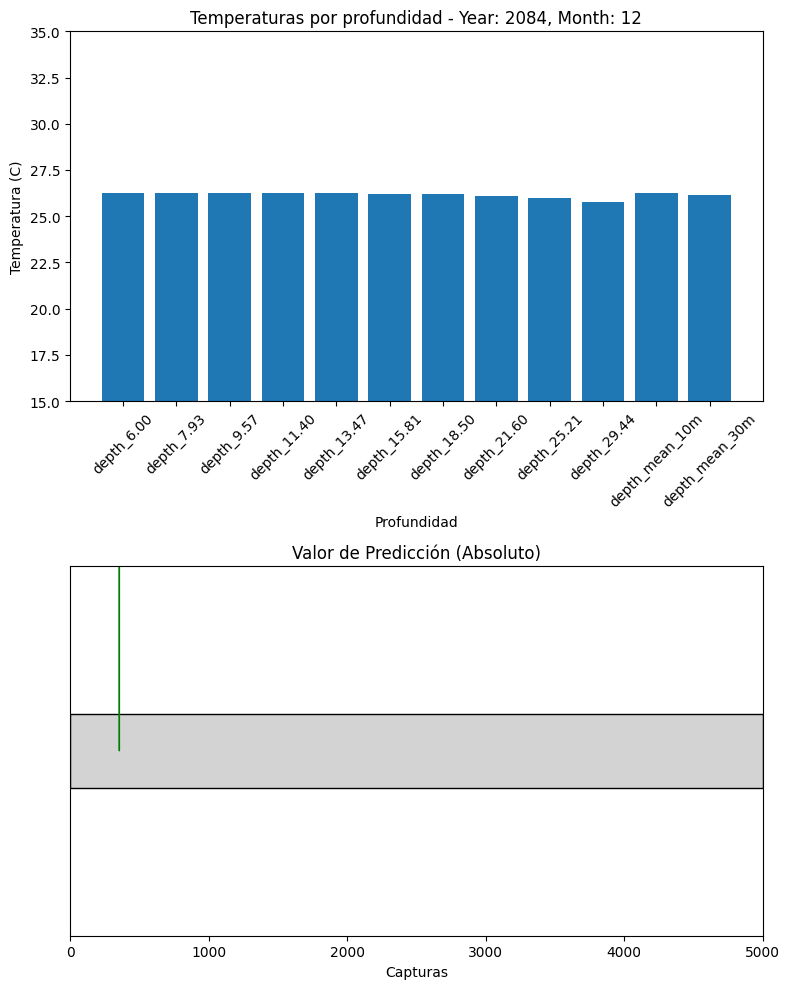

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches

# Cargar los datos desde el archivo CSV
data_path = "combined_data_for_activation.csv"
data = pd.read_csv(data_path)

# Suponiendo que los datos tienen columnas 'Year', 'Month', 'Prediction' y varias columnas de profundidad que comienzan con 'depth'
temp_columns = [col for col in data.columns if col.startswith('depth')]
data['YearMonth'] = pd.to_datetime(data['Year'].astype(str) + '-' + data['Month'].astype(str))
data = data.sort_values(by='YearMonth')

# Crear la figura y los ejes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Función para actualizar la gráfica en cada frame
def update_plot(frame):
    ax1.clear()
    ax2.clear()
    
    # Datos actuales para el frame
    current_data = data.iloc[frame]
    
    # Gráfica de barras para las temperaturas
    ax1.bar(temp_columns, current_data[temp_columns], color='#1f77b4')
    ax1.set_ylim(15, 35)
    ax1.set_title(f'Temperaturas por profundidad - Year: {current_data["Year"]}, Month: {current_data["Month"]}')
    ax1.set_xlabel('Profundidad')
    ax1.set_ylabel('Temperatura (C)')
    ax1.tick_params(axis='x', rotation=45)
    
    # Gráfica para el valor de predicción
    prediction_value = abs(current_data['predictions'])
    ax2.set_xlim(0, 5000)
    ax2.set_ylim(0, 1)
    ax2.set_title('Valor de Predicción (Absoluto)')
    ax2.set_xlabel('Capturas')
    ax2.set_yticks([])
    
    # Dibujar el rectángulo y la flecha
    rect = patches.Rectangle((0, 0.4), 5000, 0.2, linewidth=1, edgecolor='black', facecolor='lightgray')
    ax2.add_patch(rect)
    arrow = patches.FancyArrow(prediction_value, 0.5, 0, 0, width=0.1, head_width=0.3, head_length=200, color='g')
    ax2.add_patch(arrow)
    
    plt.tight_layout()

# Crear la animación
ani = animation.FuncAnimation(fig, update_plot, frames=len(data), repeat=False)

# Guardar la animación como un GIF
ani.save("output_animation.gif", writer='pillow', fps=2)

plt.show()
